## gotoflux() function

Update
* 09/25: add GP
* fixed on 09/11
* see k2phot_v2 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from glob import glob
import getpass

#fitfiles = glob('new_example_input/*.fits')
#fitfiles = glob('/home/jp/data/transit/c14/*.fits.gz')

rawlc = glob('/home/jp/github/transit/cranky/examples/*txt')

## raw

In [4]:
import pandas as pd
from astropy.stats import sigma_clip

df = pd.read_csv(rawlc[0], skiprows=1, delimiter=' ', names=['t','f','x','y'])
df['f_clip'] = sigma_clip(df.f, sigma_upper=2,sigma_lower=10)
df['fmed'] = df.f_clip.apply(lambda x: x/np.nanmedian(df.f_clip))
df['f_mask'] = df.fmed[df.fmed.apply(lambda x: (x > 0.9) & (x < 1.1))]
df.head()

,t,f,x,y,f_clip,fmed,f_mask
0,3072.723055,4137832.0,575.078681,968.525715,4137832.0,0.995498,0.995498
1,3072.743489,4140260.0,575.080944,968.524593,4140260.0,0.996082,0.996082
2,3072.763923,4143204.0,575.082971,968.521561,4143204.0,0.996791,0.996791
3,3072.784356,4145624.0,575.086262,968.519861,4145624.0,0.997373,0.997373
4,3072.804790,4147688.0,575.092265,968.517743,4147688.0,0.997869,0.997869


discarded outliers: 39


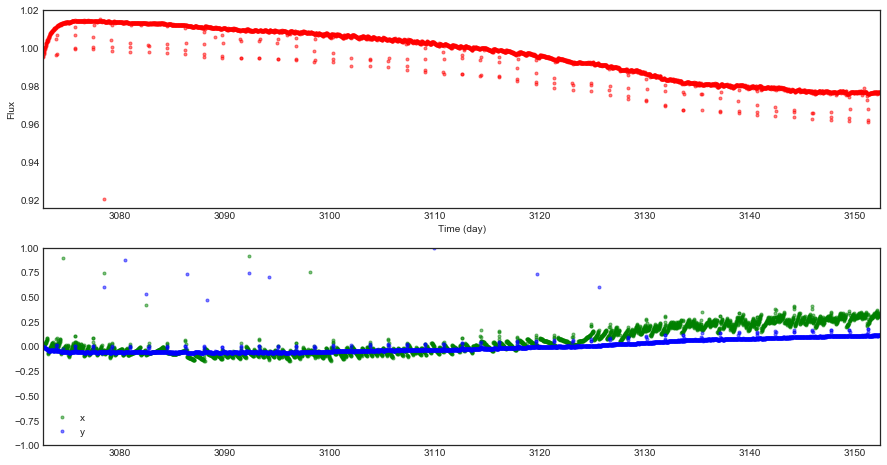

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

fig, ax = plt.subplots(2,1,figsize=(15,8))
#ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax[0].plot(df.t, df.f_mask,'.', alpha=0.5, color='r', marker='.')
ax[0].set_ylabel('Flux')
ax[0].set_xlabel('Time (day)')
#ax[0].set_ylim([np.median(df.fmed)-0.1,np.median(df.fmed)+0.1])
ax[0].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
#centroid drift
ax[1].plot(df.t, df.x.apply(lambda x: x-df.x.iloc[0]),'.', alpha=0.5, color='g', marker='.', label='x')
ax[1].plot(df.t, df.y.apply(lambda x: x-df.y.iloc[0]),'.', alpha=0.5, color='b', marker='.', label='y')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([df.t.iloc[0],df.t.iloc[-1]])
plt.legend()

print('discarded outliers: {}'.format(np.isnan(df.f_mask).sum()))

In [7]:
f = df.f/np.median(df.f)
x = df.x/np.median(df.x)
y = df.y/np.median(df.y)
t = df.t

In [12]:
from astropy.stats import sigma_clip

fmask= sigma_clip(f, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f,x,y,t=f[~mask],x[~mask],y[~mask],t[~mask]

discarded outliers: 39


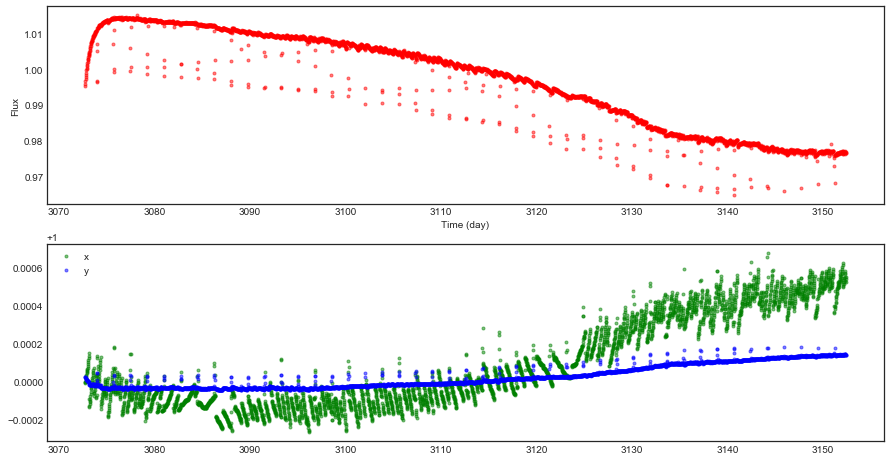

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1,figsize=(15,8))
#ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax[0].plot(t, f,'.', alpha=0.5, color='r', marker='.')
ax[0].set_ylabel('Flux')
ax[0].set_xlabel('Time (day)')
#centroid drift
ax[1].plot(t, x,'.', alpha=0.5, color='g', marker='.', label='x')
ax[1].plot(t, y,'.', alpha=0.5, color='b', marker='.', label='y')
plt.legend()

print('discarded outliers: {}'.format(np.isnan(df.f_mask).sum()))

clip transits

In [39]:
from astropy.stats import sigma_clip

fmask= sigma_clip(f, sigma=3).mask
xmask= sigma_clip(x, sigma=3).mask
ymask= sigma_clip(y, sigma=3).mask

zz = np.c_[fmask, xmask, ymask]
# idx = zz.sum(axis=1) != 0
# idx.sum()
mask=zz.any(axis=1)
f,x,y,t=f[~mask],x[~mask],y[~mask],t[~mask]

discarded outliers: 39


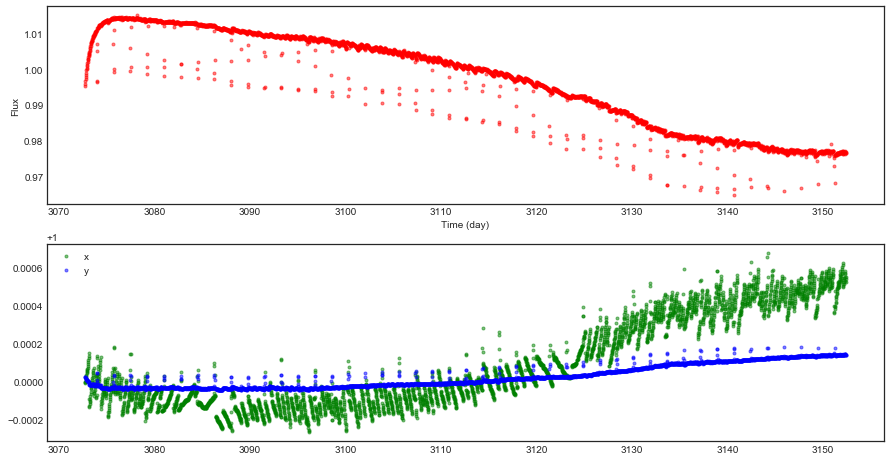

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1,figsize=(15,8))
#ax[0].plot(df.t, df.f_clip,'.', alpha=0.5, color='r', marker='.')
ax[0].plot(t, f,'.', alpha=0.5, color='r', marker='.')
ax[0].set_ylabel('Flux')
ax[0].set_xlabel('Time (day)')
#centroid drift
ax[1].plot(t, x,'.', alpha=0.5, color='g', marker='.', label='x')
ax[1].plot(t, y,'.', alpha=0.5, color='b', marker='.', label='y')
plt.legend()

print('discarded outliers: {}'.format(np.isnan(df.f_mask).sum()))

In [36]:
import george

george.__version__

'0.2.1'

In [37]:
from george.kernels import ExpSquaredKernel

kernel = ExpSquaredKernel(0.01)
gp = george.GP(kernel)

gp.compute(t, np.nanstd(f))

# Compute the log likelihood.
print(gp.lnlikelihood(f))

mu, cov = gp.predict(f,t)
std = np.sqrt(np.diag(cov))

8443.45162801


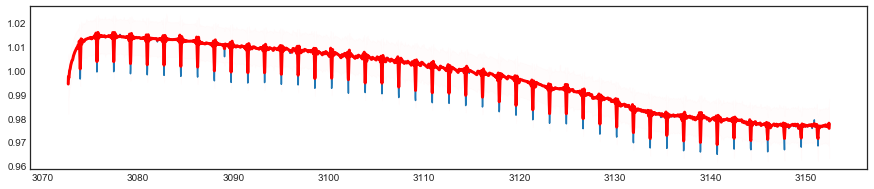

In [33]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t,f)
ax.plot(t,mu,'r-',lw=3)
ax.fill_between(t, mu-std,mu+std, color='r', alpha=0.01)

(0.98, 1.01)

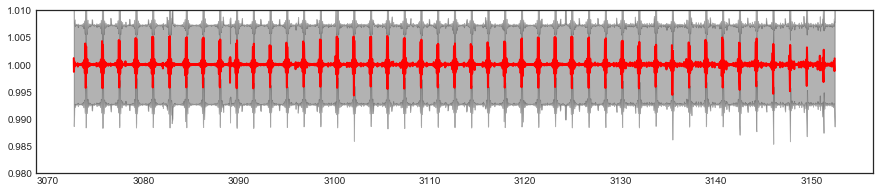

In [34]:
fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t,f/mu,'r-',lw=2)

n=1
ax.fill_between(t, f-mu-n*std+1.0,f-mu+n*std+1.0, color='k', alpha=0.3)
ax.set_ylim(0.98,1.01)

In [29]:
from gatspy.periodic import LombScargleFast

model = LombScargleFast().fit(t, f/mu)
periods, power = model.periodogram_auto(nyquist_factor=100)

In [30]:
periods[periods > 1][np.argmax(power[periods > 1])]

1.0190671943711733

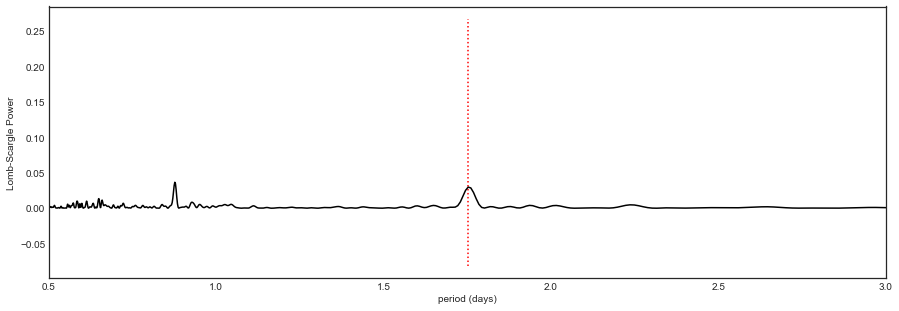

In [100]:
#get positive periods
idx1 = periods > 1
#
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 3),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

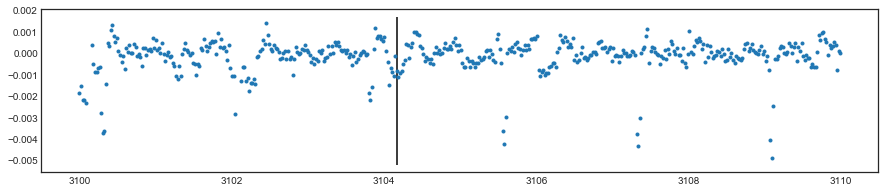

In [101]:
idx = (3100 < t) & (t < 3110)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

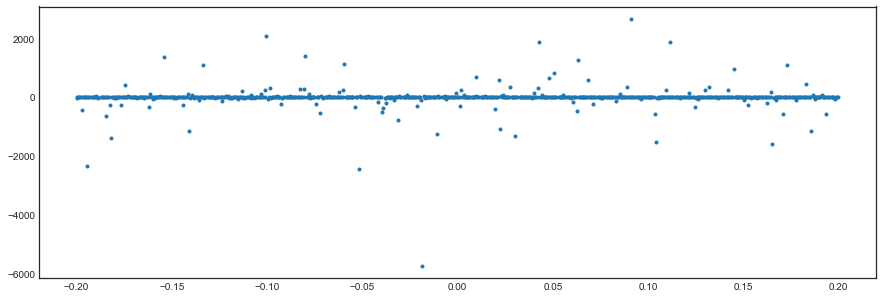

In [102]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def extract_individual(star, p, t0, width=1):

    t, f = star.time, star.flux
    idx = np.isfinite(t) & np.isfinite(f)
    t, f = t[idx], f[idx]

    tns =  get_tns(t, p, t0)

    transits = []
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        if idx.sum() == 0:
            continue
        ti = t[idx].tolist()
        fi = f[idx].tolist()
        transits.append((ti,fi))

    return transits

def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

tf, ff = fold(t, f, peak, t0)


fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')

In [103]:
import pandas as pd

d = glob(os.path.join(folders[1],'folded_*.txt'))[0]

In [105]:
df = pd.read_csv(d, skiprows=1, delimiter=' ', names=['t','f'])
# f_ = sigma_clip(df.f,sigma=2)
# df['f_clip'] = f_
df.head()

,t,f
0,0.000000,0.000735
1,0.000815,0.000203
2,0.000929,0.000050
3,0.001518,-0.000569
4,0.002332,0.000236


(1, 1.3)

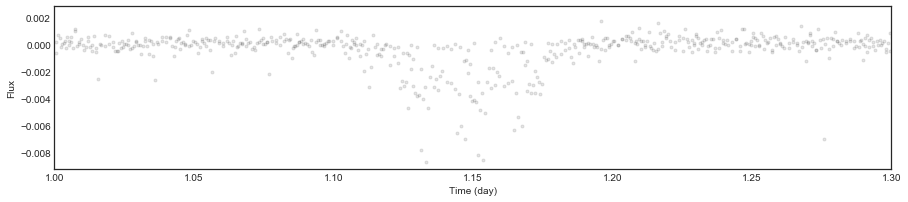

In [113]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
ax.plot(df.t, df.f,'.', alpha=0.1, color='k', marker='.')
ax.set_ylabel('Flux')
ax.set_xlabel('Time (day)')
#ax.set_xlim([df.t.iloc[0],df.t.iloc[-1]])
ax.set_xlim([1,1.3])

In [114]:
from pytransit import MandelAgol

In [ ]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf

    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [120]:
p = peak
t14 = 0.10
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1


initial = k,t0,p,a,i,u1,u2,sig,0,0,0,0
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

True
[  7.07496783e-02   2.54360933e-06   1.22357551e-04   8.54103828e-03
   1.44787099e+00   4.21974829e-02   1.95641134e-02   3.58334007e-03
   1.18382502e-02  -8.57069642e-03  -1.17751332e-03   8.23178299e-06]


In [121]:
opt.x[1], opt.x[2]

(2.5436093308382004e-06, 0.00012235755123198819)

In [122]:
#t, f, p, t0

In [ ]:
t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [ ]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball

# initial = opt.x

ndim = len(initial)
nwalkers = 8 * ndim
nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=4)
pos0 = sample_ball(initial, [1e-1]*ndim, nwalkers)

width = 3000
print("\nstage 1")
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps1)):
    n = int((width+1) * float(i) / nsteps1)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

print("\nstage 2")
idx = np.argmax(sampler.lnprobability)
best = sampler.flatchain[idx]
pos0 = sample_ball(best, [1e-5]*ndim, nwalkers)
sampler.reset()

for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps2)):
    n = int((width+1) * float(i) / nsteps2)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

In [8]:
from astropy.io import fits

hdulist=fits.open(fitfiles[0])
hdulist

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f21af2d8690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f21af2f4f10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f21af303c10>]

In [9]:
#BinTableHDU
rec = hdulist[1].data

In [9]:
time=rec.TIME
time.shape

(3895,)

In [10]:
f=rec.RAW_CNTS
f.shape

(3895, 15, 13)

In [11]:
fmean=np.nanmean(f,axis=0)
fmean.shape

(15, 13)

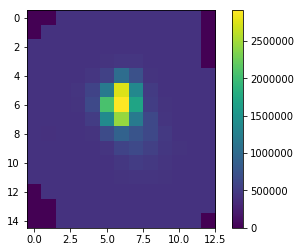

In [12]:
pl.imshow(fmean)
pl.colorbar()

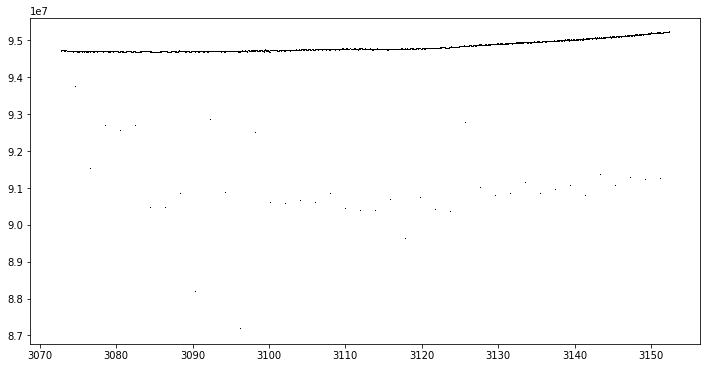

In [14]:
fig = pl.figure(figsize=(12,6))

fpix = f.reshape(f.shape[0], -1)
pl.plot(time, np.nansum(fpix, axis=1), 'k,')
#pl.ylim(4.1e7,4.18e7)